## The pandas package

#### The day of the PhD defense is near!

Your defense is set for tomorrow. *No panic!* Let's go together through all your data and results to be sure that everything is in place. 

All the data you collected are in the *bcell_data.csv* file. You managed to collect 100 different samples. For each sample, you recorded whether it is composed of pre-B cells or immature naive B cells, the sex of the donor, as well as the expression level of the IKZF1, MYC and MAPK1 genes.

In [150]:
# loading packages
import numpy as np
import pandas as pd

# exercise: read the bcell_data.csv file from the "./data" folder 
# and store the data frame in the variable "data". 
# The row names are on the first column of the file.
data = pd.read_csv('./data/bcell_data.csv', index_col=0)

# this shows the contents of data frame
print("Data successfully loaded. First 5 rows:")
print(data.head())


Data successfully loaded. First 5 rows:
       cell_type     sex      IKZF1        MYC      MAPK1
sample                                                   
s1          preB  female  17.232815  17.256758   8.864175
s2          preB    male  11.938779  12.497435   3.871096
s3          preB  female  10.153002  10.834510  10.789578
s4          preB    male  12.516865  12.115241   7.177412
s5          preB  female  11.231450  12.074468   3.356356


In [151]:
# tip: the "read_csv" function has an "index_col" parameter

Great, let's make a table that subdivides the samples according to `cell_type` and `sex`

In [152]:
# exercise: use the "crosstab" funtion for computing how many samples there are
# for each combination of cell_type and sex values
type_x_sex = pd.crosstab(data['cell_type'], data['sex'])

print("Crosstab of samples by cell type and sex:")
print(type_x_sex)


Crosstab of samples by cell type and sex:
sex        female  male
cell_type              
immatureB      25    25
preB           25    25


In [153]:
# tip: we saw the "crosstab" function in the coding lessons :-)

Your experiment is perfectly balanced, good! Let's now explore the gene expression levels, starting with visualizing them as boxplot

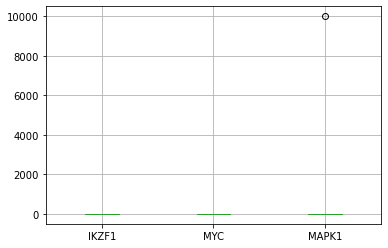

In [154]:
# boxplot for the gene expression values
data.boxplot()

It seems that there is an outlier in the MAPK1 column! Can you set that extreme value to NaN?

In [155]:

# exercise: set any value in MAPK1 that is larger than 1000 to NaN
data.loc[data['MAPK1'] > 1000, 'MAPK1'] = np.nan

print("\nOutlier values in MAPK1 column set to NaN.")
# You can verify by checking the max value now
print(f"New max value for MAPK1: {data['MAPK1'].max()}")



Outlier values in MAPK1 column set to NaN.
New max value for MAPK1: 12.881950900000001


In [156]:
# tip: you first need to finds the MAPK1 values larger than 1000, and then you must set them to NaN

Let's check if you successfully removed the outlier! 

In [157]:
# exercise: compute the number of missing value for each column
num_na = data.isna().sum()

print("\nNumber of missing values per column:")
print(num_na)



Number of missing values per column:
cell_type    0
sex          0
IKZF1        1
MYC          1
MAPK1        1
dtype: int64


If you can distintively see three boxplots then you successfully removed the outlier.

We now have introduced at least one NaN value in the MAPK1 column. Can you detect how many missing values there are for each column?

In [158]:
# let's create a copy of data, namely "imputed_data"
imputed_data = data.copy()

# exercise: replace missing values in imputed_data with the average of their respective columns
# A clean way is to calculate the means of numeric columns and pass that to fillna
imputed_data.fillna(imputed_data.mean(numeric_only=True), inplace=True)

# let's check that no missing data are present anymore in imputed_data
print("\nMissing values after imputation:")
print(imputed_data.isna().sum())



Missing values after imputation:
cell_type    0
sex          0
IKZF1        0
MYC          0
MAPK1        0
dtype: int64


In [159]:
# tip: try to combine the "isna" and "sum" methods

It seems we have some missing value in the numeric columns. Can you replace them with the average of their respective columns?

In [160]:
# this function computes the t-statistic for a numeric vector according to a binary factor
def t_statistic(v, f) :
    
    # factor unique values
    uv = f.unique()
    if len(uv) != 2:
        return np.nan # Not a binary factor

    # splitting the vector according to the factor values
    v1 = v[f == uv[0]]
    v2 = v[f == uv[1]]
    
    # t-statistic using Welch's t-test formula with sample standard deviation (ddof=1)
    mean1, mean2 = np.mean(v1), np.mean(v2)
    std1, std2 = np.std(v1, ddof=1), np.std(v2, ddof=1)
    n1, n2 = len(v1), len(v2)

    # Avoid division by zero if a group is empty or has one member
    if n1 < 2 or n2 < 2:
        return np.nan
        
    denominator = np.sqrt(std1**2 / n1 + std2**2 / n2)
    if denominator == 0:
        return np.nan

    return (mean1 - mean2) / denominator

# exercise: use the "apply" method for applying the t_statistic function to each numerical column.
# Use cell type as binary factor (argument f)

numerical_cols = ['IKZF1', 'MYC', 'MAPK1']

# Apply the function, correctly handling potential missing values from the original 'data'
res = data[numerical_cols].apply(
    lambda col: t_statistic(
        v=col.dropna(),
        f=data.loc[col.dropna().index, 'cell_type']
    )
)

print("\nCalculated T-statistics:")
print(res)



Calculated T-statistics:
IKZF1    5.012358
MYC      4.904619
MAPK1    1.194541
dtype: float64


In [161]:
# tip: the "fillna" method could be useful here

Time to better explore the data. Let's plot the distribution of the gene expression data subdivided by cell_type.

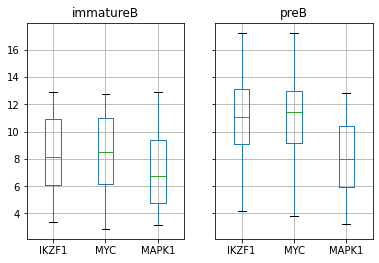

In [162]:
# distribution of the gene expression columns by cell_type
tmp = data.groupby('cell_type').boxplot()

It seems that the expression of IKZF1 and MYC is higher in the preB cells than in the immature ones. Let's compute a t statistic for assessing differences in a quantitative way.

In [163]:
# this function computes the t-statistic for a numeric vector according to a binary factor
def t_statistic(v, f) :
    
    # factor unique values
    uv = list(set(f))
    
    # splitting the vector according to the factor values
    v1 = v[list(f == uv[0])]
    v2 = v[list(f == uv[1])]
    
    # t-statistic
    return (np.mean(v1) - np.mean(v2)) / np.sqrt(np.std(v1) ** 2 / len(v1) + np.std(v2) ** 2 / len(v2) )

# exercise: use the "apply" method for applying the t_statistic function to each numerical column.
# Use cell type as binary factor (argument f)

# res = ...


In [164]:
# tip: you must use the "apply" method only on the numerical columns (IKZF1, MYC and MAPK1, in order)

If your computations are correct, you will find that the t-statistics for IKZF1 and MYC are largely beyond the critical value of 1.96 (corresponding to a p-value of 0.05). Once again, you have demonstrated the validity of your findings! You can sleep tight, tomorrow defense will be a success :-)